## Linear Regression 


Discuss one of the foundational algorithms in machine learning: Linear regression and create a model that predicts crop yields for apples and oranges (target variables) by looking at the average temperature, rainfall, and humidity (input variables or features) in a region. Here's the training data:

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2


The learning part of linear regression is to figure out a set of weights w11, w12,... w23, b1 & b2 using the training data, to make accurate predictions for new data. The learned weights will be used to predict the yields for apples and oranges in a new region using the average temperature, rainfall, and humidity for that region.


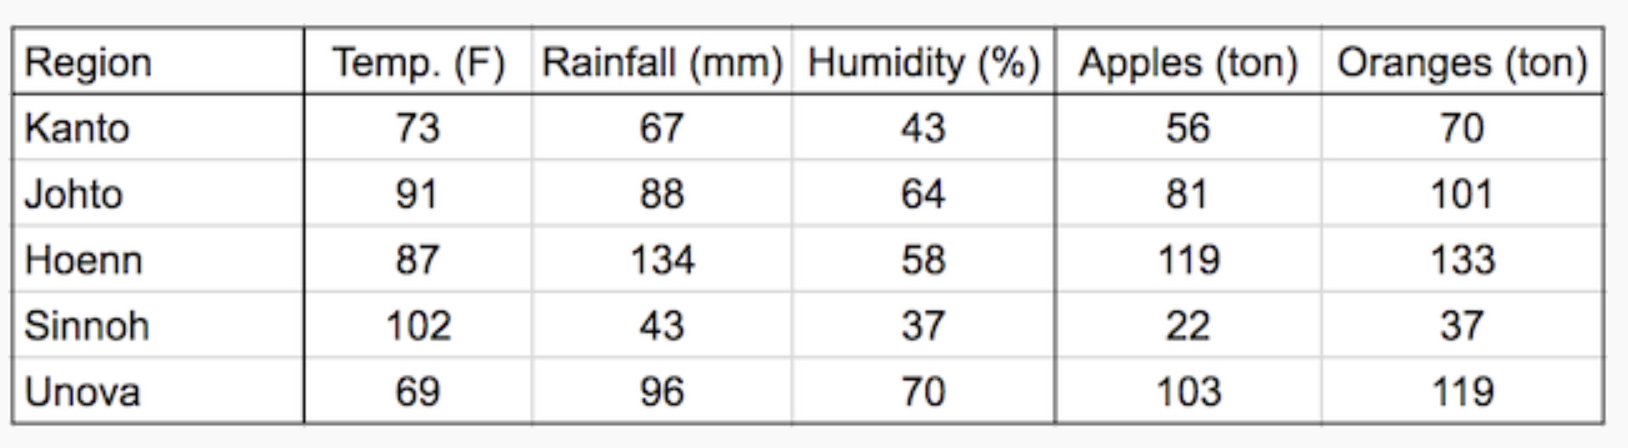

In [1]:
import torch
import numpy as np

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [3]:
# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

In [4]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [5]:
inputs.shape

torch.Size([5, 3])

In [6]:
targets.shape

torch.Size([5, 2])

## Linear regression model from scratch

The weights and biases (`w11, w12,... w23, b1 & b2`) can also be represented as matrices, initialized as random values. 

The first row of `w` and the first element of `b` are used to predict the first target variable, i.e., yield of apples, and similarly, the second for oranges.


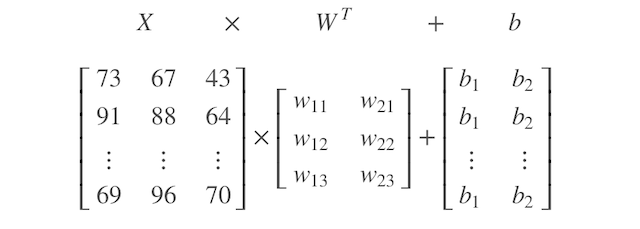

torch.randn creates a tensor with the given shape, with elements picked randomly from a normal distribution with mean 0 and standard deviation 1.

In [6]:
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)

In [7]:
w

tensor([[ 0.2273, -0.6232, -0.2125],
        [-0.2348,  0.4555, -1.0726]], requires_grad=True)

In [8]:
b

tensor([ 0.8247, -0.9034], requires_grad=True)

`@` represents matrix multiplication in PyTorch, and the `.t` method returns the transpose of a tensor.

The matrix obtained by passing the input data into the model is a set of predictions for the target variables.

In [9]:
def model(x, w, b):
    y = x @ w.t() + b
    return y


In [10]:
preds = model(inputs, w, b)
print(preds)

tensor([[-33.4763, -33.6448],
        [-46.9349, -50.8297],
        [-75.2380, -22.5015],
        [-10.6525, -44.9501],
        [-58.1959, -48.4561]], grad_fn=<AddBackward0>)


In [11]:
# 5, 3  * 3, 2  + 5, 2  == 5, 2

In [12]:
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


Loss function
Before we improve our model, we need a way to evaluate how well our model is performing. We can compare the model's predictions with the actual targets using the following method:

Calculate the difference between the two matrices (preds and targets).
Square all elements of the difference matrix to remove negative values.
Calculate the average of the elements in the resulting matrix.
The result is a single number, known as the mean squared error (MSE).

In [13]:
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff*diff)/diff.numel()

In [14]:
loss = mse(preds, targets)
loss

tensor(18188.4590, grad_fn=<DivBackward0>)

In [15]:
loss.backward()

In [16]:
w.grad

tensor([[ -9905.1250, -12031.9883,  -7158.5947],
        [-10964.9160, -12148.4102,  -7589.3979]])

In [17]:
b.grad

tensor([-121.0995, -132.0764])

We multiply the gradients with a very small number (`10^-5` in this case) to ensure that we don't modify the weights by a very large amount. We want to take a small step in the downhill direction of the gradient, not a giant leap. This number is called the *learning rate* of the algorithm. 

We use `torch.no_grad` to indicate to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases.

In [18]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

In [19]:
w,b

(tensor([[ 0.3263, -0.5029, -0.1409],
         [-0.1251,  0.5770, -0.9967]], requires_grad=True),
 tensor([ 0.8259, -0.9020], requires_grad=True))

In [20]:
preds2 = model(inputs, w, b)

In [21]:
loss2= mse(preds2, targets)
print(loss2)

tensor(12546.6973, grad_fn=<DivBackward0>)


Before we proceed, we reset the gradients to zero by invoking the `.zero_()` method. We need to do this because PyTorch accumulates gradients. Otherwise, the next time we invoke `.backward` on the loss, the new gradient values are added to the existing gradients, which may lead to unexpected results.

In [22]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


In [23]:
# Generate predictions
preds2

tensor([[-15.1047, -14.2362],
        [-22.7504, -25.3025],
        [-46.3445,   7.7201],
        [  7.2743, -25.7327],
        [-34.7984, -23.9139]], grad_fn=<AddBackward0>)

## Gradient Descent

Train the model using gradient descent
As seen above, we reduce the loss and improve our model using the gradient descent optimization algorithm. Thus, we can train the model using the following steps:

> Generate predictions

> Calculate the loss

> Compute gradients w.r.t the weights and biases

> Adjust the weights by subtracting a small quantity proportional to the gradient

> Reset the gradients to zero

### Adjust weights and biases to reduce the loss

The loss is a [quadratic function](https://en.wikipedia.org/wiki/Quadratic_function) of our weights and biases, and our objective is to find the set of weights where the loss is the lowest. If we plot a graph of the loss w.r.t any individual weight or bias element, it will look like the figure shown below. An important insight from calculus is that the gradient indicates the rate of change of the loss, i.e., the loss function's [slope](https://en.wikipedia.org/wiki/Slope) w.r.t. the weights and biases.

If a gradient element is **positive**:

* **increasing** the weight element's value slightly will **increase** the loss
* **decreasing** the weight element's value slightly will **decrease** the loss

![postive-gradient](https://i.imgur.com/WLzJ4xP.png)

If a gradient element is **negative**:

* **increasing** the weight element's value slightly will **decrease** the loss
* **decreasing** the weight element's value slightly will **increase** the loss

![negative=gradient](https://i.imgur.com/dvG2fxU.png)

The increase or decrease in the loss by changing a weight element is proportional to the gradient of the loss w.r.t. that element. This observation forms the basis of _the gradient descent_ optimization algorithm that we'll use to improve our model (by _descending_ along the _gradient_).

We can subtract from each weight element a small quantity proportional to the derivative of the loss w.r.t. that element to reduce the loss slightly.

In [24]:
# Generate predictions
preds = model(inputs, w, b)
print(preds)

tensor([[-15.1047, -14.2362],
        [-22.7504, -25.3025],
        [-46.3445,   7.7201],
        [  7.2743, -25.7327],
        [-34.7984, -23.9139]], grad_fn=<AddBackward0>)


In [25]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(12546.6973, grad_fn=<DivBackward0>)


In [26]:
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[-8005.4014, -9982.4121, -5895.6494],
        [-8960.3828, -9992.6396, -6259.3672]])
tensor([ -98.5447, -108.2930])


In [27]:
# Adjust weights & reset gradients
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [28]:
w, b

(tensor([[ 0.4064, -0.4031, -0.0819],
         [-0.0355,  0.6769, -0.9341]], requires_grad=True),
 tensor([ 0.8269, -0.9010], requires_grad=True))

In [30]:
# Calculate loss
preds = model(inputs, w, b)
loss = mse(preds, targets)
print(loss)

tensor(8741.6338, grad_fn=<DivBackward0>)


### Training for multiple epochs

In [31]:
def train(num_epochs, learning_rate):
    
    w = torch.randn(2,3,requires_grad=True)
    b = torch.randn(2, requires_grad=True)
    
    for i in range(num_epochs):
        preds = model(inputs, w, b)
        loss = mse(preds, targets)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * learning_rate
            b -= b.grad * learning_rate

            w.grad.zero_()
            b.grad.zero_()
        
        if i%10 == 0:
            print(f"Loss at {i} iteration ===>  {loss}")


In [34]:
train(51, 1e-5)

Loss at 0 iteration ===>  35616.80859375
Loss at 10 iteration ===>  2074.009033203125
Loss at 20 iteration ===>  1271.099365234375
Loss at 30 iteration ===>  1118.829345703125
Loss at 40 iteration ===>  995.2595825195312
Loss at 50 iteration ===>  886.4562377929688


## Linear Regression Using InBuilt Functions

In [35]:
import torch.nn as nn

In [36]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70], 
                   [74, 66, 43], 
                   [91, 87, 65], 
                   [88, 134, 59], 
                   [101, 44, 37], 
                   [68, 96, 71], 
                   [73, 66, 44], 
                   [92, 87, 64], 
                   [87, 135, 57], 
                   [103, 43, 36], 
                   [68, 97, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119],
                    [57, 69], 
                    [80, 102], 
                    [118, 132], 
                    [21, 38], 
                    [104, 118], 
                    [57, 69], 
                    [82, 100], 
                    [118, 134], 
                    [20, 38], 
                    [102, 120]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

### Dataset and DataLoader

Create a `TensorDataset`, which allows access to rows from `inputs` and `targets` as tuples, and provides standard APIs for working with many different types of datasets in PyTorch.

In [37]:
from torch.utils.data import TensorDataset

In [38]:
dataset = TensorDataset(inputs, targets)

In [39]:
dataset

In [40]:
dataset.tensors

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.],
         [ 74.,  66.,  43.],
         [ 91.,  87.,  65.],
         [ 88., 134.,  59.],
         [101.,  44.,  37.],
         [ 68.,  96.,  71.],
         [ 73.,  66.,  44.],
         [ 92.,  87.,  64.],
         [ 87., 135.,  57.],
         [103.,  43.,  36.],
         [ 68.,  97.,  70.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.],
         [ 22.,  37.],
         [103., 119.],
         [ 57.,  69.],
         [ 80., 102.],
         [118., 132.],
         [ 21.,  38.],
         [104., 118.],
         [ 57.,  69.],
         [ 82., 100.],
         [118., 134.],
         [ 20.,  38.],
         [102., 120.]]))

In [41]:
from torch.utils.data import DataLoader

In [43]:
data_loader = DataLoader(dataset=dataset, batch_size=3, shuffle=True)

In [44]:
for xb, yb in data_loader:
    print(xb, yb)

tensor([[69., 96., 70.],
        [68., 97., 70.],
        [73., 66., 44.]]) tensor([[103., 119.],
        [102., 120.],
        [ 57.,  69.]])
tensor([[ 87., 135.,  57.],
        [ 88., 134.,  59.],
        [ 87., 134.,  58.]]) tensor([[118., 134.],
        [118., 132.],
        [119., 133.]])
tensor([[91., 87., 65.],
        [91., 88., 64.],
        [73., 67., 43.]]) tensor([[ 80., 102.],
        [ 81., 101.],
        [ 56.,  70.]])
tensor([[101.,  44.,  37.],
        [102.,  43.,  37.],
        [103.,  43.,  36.]]) tensor([[21., 38.],
        [22., 37.],
        [20., 38.]])
tensor([[74., 66., 43.],
        [68., 96., 71.],
        [92., 87., 64.]]) tensor([[ 57.,  69.],
        [104., 118.],
        [ 82., 100.]])


### Model

In [45]:
# Define model

model = nn.Linear(in_features=3, out_features=2)

In [50]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0321,  0.5190, -0.5060],
         [ 0.5255,  0.1338, -0.1635]], requires_grad=True),
 Parameter containing:
 tensor([-0.2307, -0.1241], requires_grad=True)]

### Loss

In [53]:
# Import nn.functional
import torch.nn.functional as F

In [54]:
# Define loss function
loss_fn = F.mse_loss

### Optimizer

In [55]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SGD

In [56]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
        
        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [59]:
fit(100, model, loss_fn, opt, data_loader)

Epoch [10/100], Loss: 245.0858
Epoch [20/100], Loss: 229.6710
Epoch [30/100], Loss: 114.1627
Epoch [40/100], Loss: 210.3571
Epoch [50/100], Loss: 58.0106
Epoch [60/100], Loss: 104.9792
Epoch [70/100], Loss: 26.7225
Epoch [80/100], Loss: 33.1833
Epoch [90/100], Loss: 43.6984
Epoch [100/100], Loss: 21.0700


In [60]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 57.5320,  71.1015],
        [ 77.7539,  97.0906],
        [126.6714, 139.3306],
        [ 24.1997,  41.7215],
        [ 92.4218, 110.1752],
        [ 56.2251,  70.0055],
        [ 76.8162,  96.5301],
        [126.5414, 139.5903],
        [ 25.5066,  42.8176],
        [ 92.7910, 110.7107],
        [ 56.5943,  70.5410],
        [ 76.4470,  95.9946],
        [127.6091, 139.8911],
        [ 23.8305,  41.1860],
        [ 93.7287, 111.2712]], grad_fn=<AddmmBackward0>)